<h5>AnyLogistics Tutorial</h5>

In this notebook we model a scenario using SupplyNetPy that is available in AnyLogistix tutorials, and try to generate similar performance stats.
The AnyLogistix simulation scenario tutorial can be found [here](https://anylogistix.help/tutorial/tutorial-simulation-main.html).

We have further simplified the system be including only one supplier, three distribution centers, and four retailers.

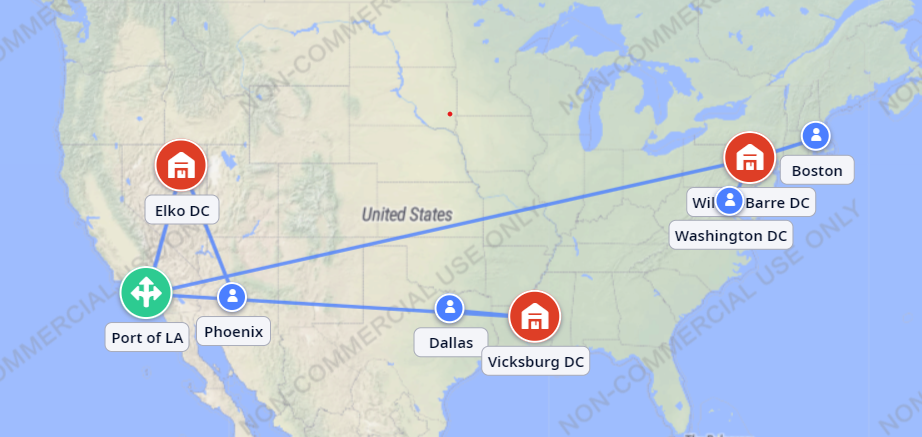

We will create a similar model with same configuration (parameter values) to generate same stats.

INFO sim_trace - 0:d1:Demand at Wilkes-Barre DC, Order quantity:118 received, inventory level:800.
INFO sim_trace - 0:d1:Demand at Elko DC, Order quantity:108 received, inventory level:892.
INFO sim_trace - 0:d1:Demand at Vicksburg DC, Order quantity:225 received, inventory level:775.
INFO sim_trace - 0:d1:Demand at Wilkes-Barre DC, Order quantity:82 received, inventory level:800.
INFO sim_trace - 1:D1: Inventory levels:800
INFO sim_trace - 1:D2: Inventory levels:775
INFO sim_trace - 1:D1: Inventory levels:892
INFO sim_trace - 2:D1: Inventory levels:800
INFO sim_trace - 2:D2: Inventory levels:775
INFO sim_trace - 2:D1: Inventory levels:784
INFO sim_trace - 2:d1:Demand at Elko DC, Order quantity:108 received, inventory level:784.
INFO sim_trace - 3:D1: Inventory levels:800
INFO sim_trace - 3:D2: Inventory levels:775
INFO sim_trace - 3:D1: Inventory levels:784
INFO sim_trace - 4:D1: Inventory levels:733
INFO sim_trace - 4:D2: Inventory levels:775
INFO sim_trace - 4:D1: Inventory levels:6

Washington DC unsatisfied demand: 0
Phoenix unsatisfied demand: 0
Dallas unsatisfied demand: 0
Boston unsatisfied demand: 0
Total Inventory Cost Wilkes-Barre DC:  3578478 , Transportation cost: 0
Total Inventory Cost Vicksburg DC:  3539700 , Transportation cost: 0
Total Inventory Cost Elko DC:  2907840 , Transportation cost: 0
Total Transportation Cost:  0
Total Supply Chain Cost:  44026018


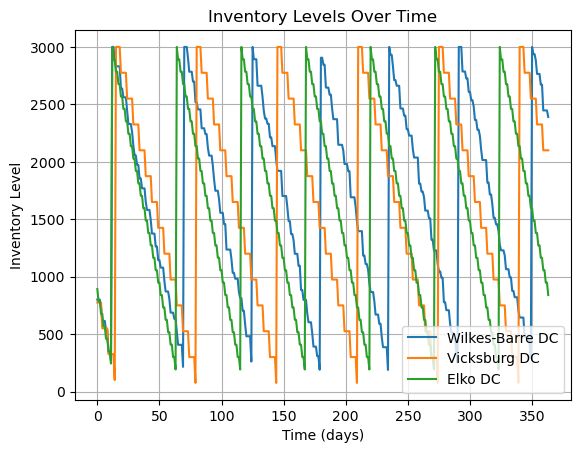

In [1]:
import SupplyNetPy.Components as scm
import simpy
import numpy as np
import random
import matplotlib.pyplot as plt

def uniform_period():
    return np.random.randint(2, 5)

def uniform_quantity():
    return np.random.randint(46, 115)

simlen = 365 # simulation length in days
env = simpy.Environment()

# create an infinite supplier
supplier1 = scm.Supplier(env=env, ID="S1", name="Port of LA", node_type="infinite_supplier")

"""
Transportation cost is dependent on the distance between the supplier and the distributor.
Distances (approx) from Port of LA to 
    Elko DC = 1100 km
    Wilkes-Barre DC = 4400 km
    Vicksburg DC = 2910 km

Transportation cost = 0.002*(order size)*(distance in km)
Average order size is 2700 units, since the capacity of these distributors is 3000 units and the reorder point is 300 units.

Therfore, the transportation cost is calculated as follows:
    Elko DC = 0.002*2700*1100 = 5940
    Wilkes-Barre DC = 0.002*2700*4400 = 23760
    Vicksburg DC = 0.002*2700*2910 = 15714

Shipment processing cost is given for distribution centers as follows:
    Wilkes-Barre DC = 0.52
    Vicksburg DC = 0.58
    Elko DC = 0.56
"""

#create the distributor
distributor1 = scm.InventoryNode(env=env, ID="D1", name="Wilkes-Barre DC", node_type="distributor",
                                capacity=3000, initial_level=1000, inventory_holding_cost=6,
                                replenishment_policy="sS", policy_param=[300], product_sell_price=399)

distributor2 = scm.InventoryNode(env=env, ID="D2", name="Vicksburg DC", node_type="distributor",
                                capacity=3000, initial_level=1000, inventory_holding_cost=6,
                                replenishment_policy="sS", policy_param=[300], product_sell_price=399)

distributor3 = scm.InventoryNode(env=env, ID="D1", name="Elko DC", node_type="distributor",
                                capacity=3000, initial_level=1000, inventory_holding_cost=5,
                                replenishment_policy="sS", policy_param=[300], product_sell_price=399)

link1 = scm.Link(env=env,ID="l1", source=supplier1, sink=distributor1, cost=5940, lead_time=lambda: 0)
link2 = scm.Link(env=env,ID="l2", source=supplier1, sink=distributor2, cost=23760, lead_time=lambda: 0)
link3 = scm.Link(env=env,ID="l3", source=supplier1, sink=distributor3, cost=15714, lead_time=lambda: 0)

demand1 = scm.Demand(env=env,ID="d1", name="Washington DC", 
                    order_arrival_model=lambda: 5, 
                    order_quantity_model=lambda: 118, demand_node=distributor1)

demand2 = scm.Demand(env=env,ID="d1", name="Phoenix", 
                    order_arrival_model=lambda: 2, 
                    order_quantity_model=lambda: 108, demand_node=distributor3)

demand3 = scm.Demand(env=env,ID="d1", name="Dallas", 
                    order_arrival_model=lambda: 5, 
                    order_quantity_model=lambda: 225, demand_node=distributor2)

demand4 = scm.Demand(env=env,ID="d1", name="Boston", 
                    order_arrival_model=uniform_period, 
                    order_quantity_model=uniform_quantity, demand_node=distributor1)

env.run(until=simlen)

instantaneous_levels1 = np.array(distributor1.inventory.instantaneous_levels)
instantaneous_levels2 = np.array(distributor2.inventory.instantaneous_levels)
instantaneous_levels3 = np.array(distributor3.inventory.instantaneous_levels)

for demand in [demand1, demand2, demand3, demand4]:
    unsatis_demand = np.array((demand.unsatisfied_demand))
    if len(unsatis_demand)==0:
        unsatis_demand = np.array(([[0,0]]))
    print(demand.name, "unsatisfied demand:", unsatis_demand[:,1].sum())


"""
under facility expenses, the initial cost of the facilities are given as below:
    Wilkes-Barre DC = 12600000
    Vicksburg DC = 9450000
    Elko DC = 11950000
"""
# calculate total supply chain cost
total_inv_cost1 = sum(instantaneous_levels1[:,1])*distributor1.inventory_holding_cost 
total_inv_cost2 = sum(instantaneous_levels2[:,1])*distributor2.inventory_holding_cost 
total_inv_cost3 = sum(instantaneous_levels3[:,1])*distributor3.inventory_holding_cost 
transportcost = sum([x[1] for x in distributor1.transportation_cost])
transportcost += sum([x[1] for x in distributor2.transportation_cost])
transportcost += sum([x[1] for x in distributor3.transportation_cost])

print("Total Inventory Cost Wilkes-Barre DC: ", total_inv_cost1, ", Transportation cost:", sum([x[1] for x in distributor1.transportation_cost]))
print("Total Inventory Cost Vicksburg DC: ", total_inv_cost2, ", Transportation cost:", sum([x[1] for x in distributor2.transportation_cost]))
print("Total Inventory Cost Elko DC: ", total_inv_cost3, ", Transportation cost:", sum([x[1] for x in distributor3.transportation_cost]))
print("Total Transportation Cost: ", transportcost)
print("Total Supply Chain Cost: ", total_inv_cost1 + 12600000 + total_inv_cost2 + 9450000 + total_inv_cost3 + 11950000 + transportcost)

# plotting the inventory levels over time
plt.plot(instantaneous_levels1[:,1], label="Wilkes-Barre DC")
plt.plot(instantaneous_levels2[:,1], label="Vicksburg DC")
plt.plot(instantaneous_levels3[:,1], label="Elko DC")
plt.title("Inventory Levels Over Time")
plt.xlabel("Time (days)")
plt.ylabel("Inventory Level")
plt.legend()
plt.grid()
plt.show()
